## Problem statement
In this dataset, each customer is classified as high or low credit risk according to the set of features and payment history. If label is 1, the customer is in high credit risk. Dataset imbalance ratio is 20%.

**Data:**

payment_data.csv: customer’s card payment history.
- id: customer id
- OVD_t1: number of times overdue type 1
- OVD_t2: number of times overdue type 2
- OVD_t3: number of times overdue type 3
- OVD_sum: total overdue days
- pay_normal: number of times normal payment
- prod_code(category feature): credit product code
- prod_limit: credit limit of product
- update_date: account update date
- new_balance: current balance of product
- highest_balance: highest balance in history
- report_date: date of recent payment

customer_data.csv: customer’s demographic data and category attributes which have been encoded. <br>
Category features are fea_1, fea_3, fea_5, fea_6, fea_7, fea_9.

**Tasks:**
- Explore data to give insights.
-	Build features from existing payment data.
-	Build model to predict high risk customer 
-	Model explanation and evaluation

**Solution**
0. Business questions: what are the top features of high risks customers?
1. Data exploration, visualization with PCA
2. Data preprocessing & feature engineering
3. Build starter model, decide metric 
4. Finetune model, final test score with left aside data

**My previous data analysis notebook for my own [reference](https://nbviewer.jupyter.org/github/BambooPalace/Case-Study-Airbnb-Seattle-Data/blob/master/Airbnb%20Dataset%20Analysis-V2.ipynb)**


### 1. Data exploration (EDA)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# !pip install missingno
import missingno
%matplotlib inline

In [2]:
%xmode Minimal

Exception reporting mode: Minimal


In [3]:
%ls

OCBC Anomaly detection.ipynb  payment_data_ratio20.csv
customer_data_ratio20.csv     question.txt


In [4]:
payment = pd.read_csv('payment_data_ratio20.csv')
customer = pd.read_csv('customer_data_ratio20.csv')

**Customer data**

In [5]:
customer.head()

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11
0,1,54982665,5,1245.5,3,77000.0,2,15,5,109,5,151300,244.948974
1,0,59004779,4,1277.0,1,113000.0,2,8,-1,100,3,341759,207.173840
2,0,58990862,7,1298.0,1,110000.0,2,11,-1,101,5,72001,1.000000
3,1,58995168,7,1335.5,1,151000.0,2,11,5,110,3,60084,1.000000
4,0,54987320,7,NaN,2,59000.0,2,11,5,108,4,450081,197.403141


In [6]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 13 columns):
label     1125 non-null int64
id        1125 non-null int64
fea_1     1125 non-null int64
fea_2     976 non-null float64
fea_3     1125 non-null int64
fea_4     1125 non-null float64
fea_5     1125 non-null int64
fea_6     1125 non-null int64
fea_7     1125 non-null int64
fea_8     1125 non-null int64
fea_9     1125 non-null int64
fea_10    1125 non-null int64
fea_11    1125 non-null float64
dtypes: float64(3), int64(10)
memory usage: 114.4 KB


In [7]:
customer.isnull().mean()*100
# fea_2 is 13.2 missing, as it is only missing feature, can add a feature as fea_2_missing

label      0.000000
id         0.000000
fea_1      0.000000
fea_2     13.244444
fea_3      0.000000
fea_4      0.000000
fea_5      0.000000
fea_6      0.000000
fea_7      0.000000
fea_8      0.000000
fea_9      0.000000
fea_10     0.000000
fea_11     0.000000
dtype: float64

In [8]:
# customer.describe()

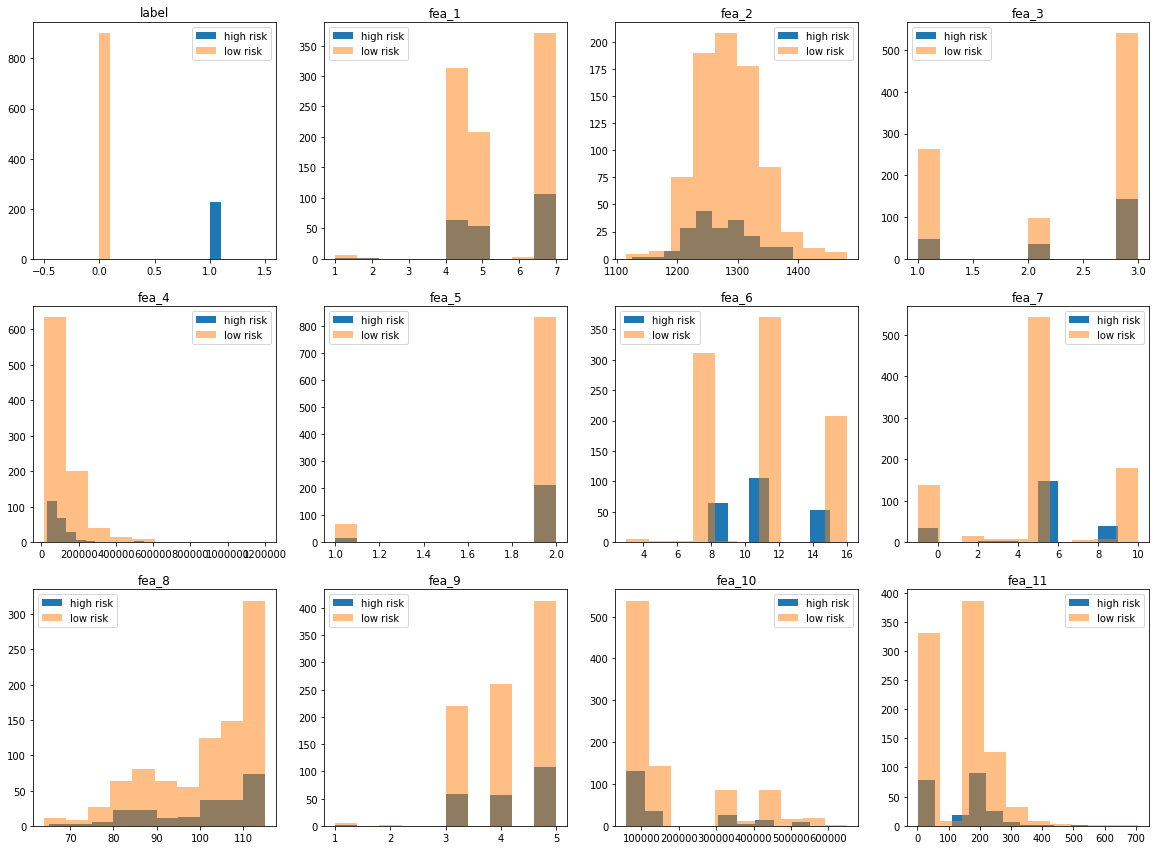

In [11]:
# Visualize feature distribution for two types
plt.subplots(figsize=(20,20))
for i in range(1, 13):
    plt.subplot(4, 4, i)
    col=customer.drop('id',axis=1).columns[i-1]
    plt.hist(customer[customer.label==1][col], label='high risk')
    plt.hist(customer[customer.label==0][col], alpha=0.5, label='low risk')
    plt.title(col)
    plt.legend()

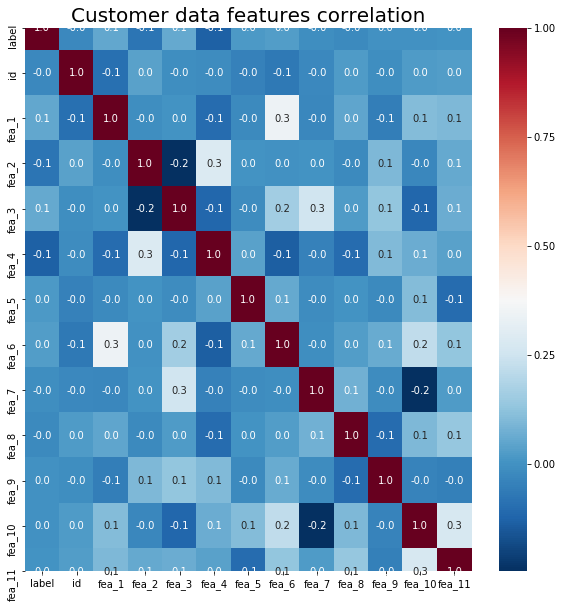

In [12]:
# check feature correlation to each other
plt.subplots(figsize =(10, 10))
sns.heatmap(customer.corr(), annot=True,cmap='RdBu_r', fmt=".1f");
plt.title('Customer data features correlation',size=20);

**Payment data**

In [13]:
payment.head()

,id,OVD_t1,OVD_t2,OVD_t3,OVD_sum,pay_normal,prod_code,prod_limit,update_date,new_balance,highest_balance,report_date
0,58987402,0,0,0,0,1,10,16500.0,04/12/2016,0.0,NaN,NaN
1,58995151,0,0,0,0,1,5,NaN,04/12/2016,588720.0,491100.0,NaN
2,58997200,0,0,0,0,2,5,NaN,04/12/2016,840000.0,700500.0,22/04/2016
3,54988608,0,0,0,0,3,10,37400.0,03/12/2016,8425.2,7520.0,25/04/2016
4,54987763,0,0,0,0,2,10,NaN,03/12/2016,15147.6,NaN,26/04/2016


In [14]:
payment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8250 entries, 0 to 8249
Data columns (total 12 columns):
id                 8250 non-null int64
OVD_t1             8250 non-null int64
OVD_t2             8250 non-null int64
OVD_t3             8250 non-null int64
OVD_sum            8250 non-null int64
pay_normal         8250 non-null int64
prod_code          8250 non-null int64
prod_limit         2132 non-null float64
update_date        8224 non-null object
new_balance        8250 non-null float64
highest_balance    7841 non-null float64
report_date        7136 non-null object
dtypes: float64(3), int64(7), object(2)
memory usage: 773.6+ KB


In [15]:
# payment data missing percentage
payment.isnull().mean()*100
#prod_limit is heavily missing, followed by report_date and highest_balance.
#Later I will decide how to keep them during data preprocessing

id                  0.000000
OVD_t1              0.000000
OVD_t2              0.000000
OVD_t3              0.000000
OVD_sum             0.000000
pay_normal          0.000000
prod_code           0.000000
prod_limit         74.157576
update_date         0.315152
new_balance         0.000000
highest_balance     4.957576
report_date        13.503030
dtype: float64

In [16]:
payment['update_date']=pd.to_datetime(payment['update_date'], format = '%d/%m/%Y')
payment['report_date']=pd.to_datetime(payment['report_date'], format = '%d/%m/%Y')

In [17]:
print('update date data ranges from {} to {}'.format(payment.update_date.min(),payment.update_date.max()))
print('report date data ranges from {} to {}'.format(payment.report_date.min(),payment.report_date.max()))

update date data ranges from 1988-07-19 00:00:00 to 2016-12-04 00:00:00
report date data ranges from 1996-02-24 00:00:00 to 2016-12-06 00:00:00


In [18]:
# payment.describe()

In [19]:
#add label data into payment dataset

#create dictionary for each pair of customer id and risk label
label_dict=dict(zip(customer.id,customer.label))
#create label column in payment data
payment['label']=payment.id.map(label_dict)

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


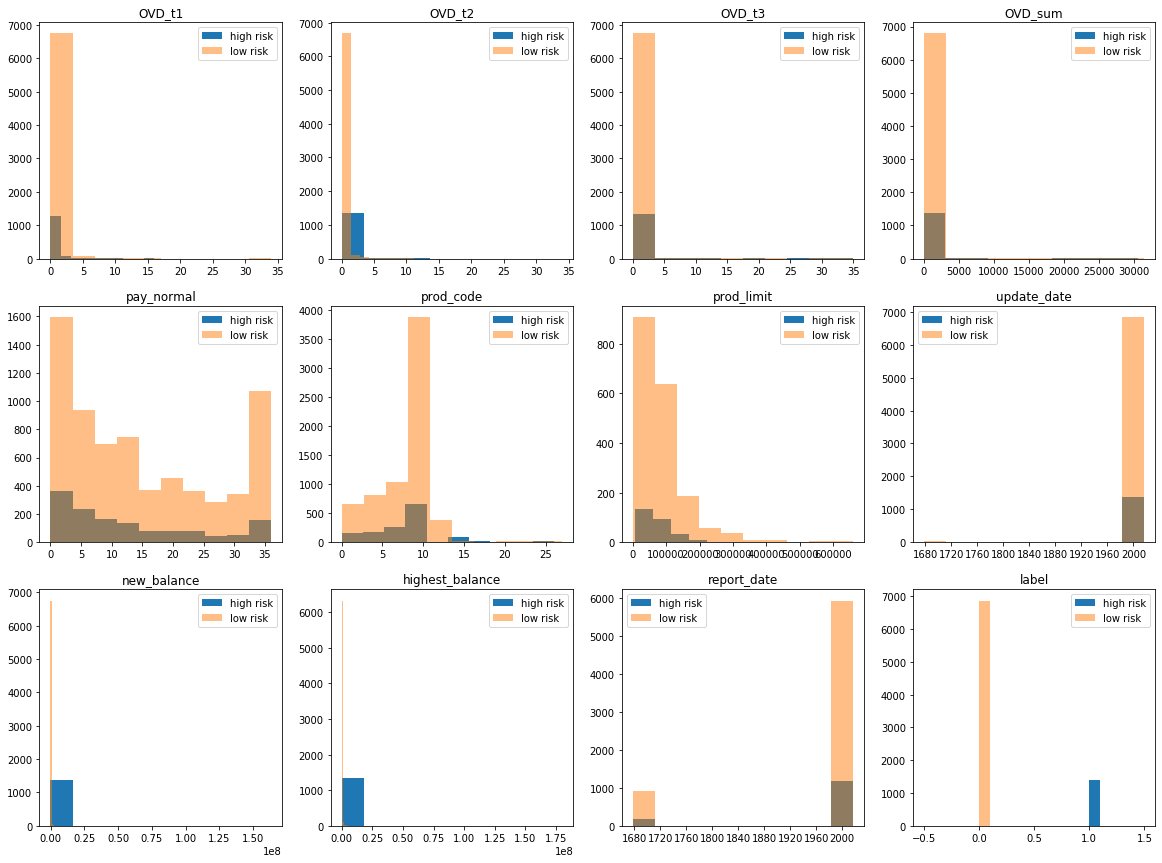

In [36]:
# Visualize feature distribution for two types
plt.subplots(figsize=(20,20))
for i in range(1, 13):
    plt.subplot(4, 4, i)
    col=payment.drop('id',axis=1).columns[i-1]
    plt.hist(payment[payment.label==1][col], label='high risk')
    plt.hist(payment[payment.label==0][col], alpha=0.5, label='low risk')
    plt.title(col)
    plt.legend()

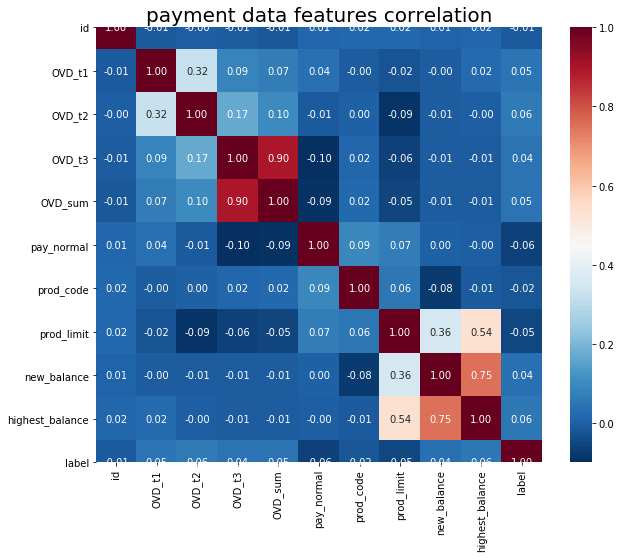

In [35]:
# check feature correlation to each other
plt.subplots(figsize =(10, 8))
sns.heatmap(payment.corr(), annot=True,cmap='RdBu_r', fmt=".2f");
plt.title('payment data features correlation',size=20);
#Strong correlation between OVD_t3 and OVD_sum, new_balance and high_balance

In [38]:
#rank feature correlation wrt label
payment.corr().label.apply(lambda x: abs(x)).sort_values(ascending=False)

label              1.000000
OVD_t2             0.061674
pay_normal         0.061594
highest_balance    0.055984
OVD_t1             0.049135
prod_limit         0.046875
OVD_sum            0.045156
OVD_t3             0.044469
new_balance        0.035648
prod_code          0.018054
id                 0.008218
Name: label, dtype: float64

## 2. Data preparation
1. Data preprocessing: imputing missing values, encoding categorical values, normalization for numerical data if necessary.
2. Feature engineering: creating new features based on existing data.

### Imputing missing data and encoding categorical data

Customer data fea_2 is 13% missing, that's much more than we should drop, instead we try impute the missing values.
There are a few strategies for imputing,one way we can predict fea_2 missing values based on its correlation with available data. From the heatmap we see no strong correlation between fea_2 and another feature.

**As fea_2 is a numerical feature, one common way is to impute with its median value. Also, only this feature is missing in the customer dataset, there might be some reason about it, I am going to create a new feature to label whether fea_2 is missing.**

**Categorical features with < 10 categories are normally recommended to perform one hot encoding.**

<font color = blue >These preprocessing steps I will incorporate into a **pipeline in the modelling section.**

In [125]:
#create a new feature to label whether fea_2 is missing
customer['fea_2_missing']=customer.fea_2.isnull().astype(int)

In [126]:
categorical_cols=['fea_1', 'fea_3', 'fea_5', 'fea_6', 'fea_7', 'fea_9','fea_2_missing']
numerical_cols=customer.drop(categorical_cols, axis=1).drop(['label','id'],axis=1).columns.to_list()

In [23]:
customer[categorical_cols].nunique()
#<10 categories, suitable for one hot encoding

fea_1             6
fea_3             3
fea_5             2
fea_6            10
fea_7            10
fea_9             5
fea_2_missing     2
dtype: int64

### Feature engineering with payment dataset
From below data exploration, I can see payment data has multiple entries for each of 1125 unique customers.

**The question is how to make payment data into a dataset reflecting each customers' behavior.**

In [24]:
customer.id.nunique()
#customer data each row points to a unique 

1125

In [25]:
payment.id.nunique()

1125

In [26]:
#check payment count per user
payment.groupby('id')['id'].count().sort_values(ascending=False)

id
58988212    55
54990497    48
58998646    45
58991343    39
58987276    39
            ..
54988373     1
54988388     1
54990536     1
59003701     1
59000105     1
Name: id, Length: 1125, dtype: int64

In [41]:
# each user has multiple payment transactions, how to use this data?
payment[payment.id == 58987276].sort_values(by='report_date', ascending=False)

,id,OVD_t1,OVD_t2,OVD_t3,OVD_sum,pay_normal,prod_code,update_date,new_balance,highest_balance,report_date,label
7699,58987276,0,0,0,0,35,10,2005-12-09,180506.4,164171.0,2016-11-04,0
5302,58987276,0,0,0,0,35,10,2011-11-27,68216.4,277949.0,2016-11-04,0
7615,58987276,0,0,0,0,36,10,2006-03-01,218883.6,239799.0,2016-11-04,0
6901,58987276,0,0,0,0,36,10,2007-11-06,113610.0,176424.0,2016-11-04,0
6969,58987276,0,0,0,0,36,10,2007-09-12,54918.0,144790.0,2016-04-30,0
6735,58987276,0,0,0,0,36,12,2008-02-22,43780.8,160500.0,2016-04-18,0
4413,58987276,0,0,0,0,33,10,2013-03-06,277701.6,NaN,2016-04-15,0
6230,58987276,0,0,0,0,36,2,2008-12-17,968368.8,1540194.0,2016-03-28,0
272,58987276,0,0,0,0,3,1,2016-01-27,381831.6,328500.0,2016-03-25,0
2272,58987276,0,0,0,0,19,1,2014-12-10,608799.6,678500.0,2016-03-23,0


In [39]:
#drop prod_limit feature as it is too sparse
payment.drop('prod_limit',axis=1, inplace=True)

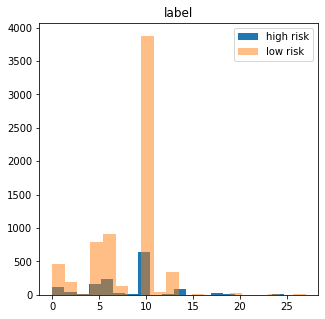

In [44]:
plt.subplots(figsize=(5,5))
plt.hist(payment[payment.label==1]['prod_code'], label='high risk', bins=20)
plt.hist(payment[payment.label==0]['prod_code'], alpha=0.5, label='low risk', bins=20)
plt.title(col)
plt.legend()

### Payment feature engineering method 1
1. Calculate the `account active period`, i.e. range of report date for each id
2. Drop two date features,product code(only categorical)
3. User behavior methodology: Group by id, **sum** all (numerical) features and **divide these values by active period** to calculate the average behavior for each user.
4. combine payment data and customer data

In [72]:
# 1. Calculate the `account active period`, i.e. range of report date for each id
active_period=pd.to_numeric(payment.groupby('id').report_date.max()
                            -payment.groupby('id').report_date.min())/86400000000000.0  # convert to no. of days

active_period.head()

id
54982353    4411.0
54982356    3438.0
54982387    1941.0
54982463     759.0
54982530      61.0
Name: report_date, dtype: float64

In [107]:
# 2. Drop two date features,product code(only categorical)
payment_v1=payment.drop(['report_date','update_date','prod_code'], axis=1)

In [108]:
features=payment_v1.columns.drop('label')

In [109]:
# 3. sum numerical features
payment_v1=payment_v1[features].groupby('id').sum()
payment_v1['active_period']=active_period

# divide numbers by active days
for col in payment_v1.columns.drop('active_period'):
    payment_v1[col]=payment_v1[col]/payment_v1['active_period']


In [110]:
payment_v1.head()

,OVD_t1,OVD_t2,OVD_t3,OVD_sum,pay_normal,new_balance,highest_balance,active_period
id,,,,,,,,
54982353,0.000680,0.000453,0.008615,7.272274,0.051916,171.524915,782.627976,4411.0
54982356,0.000000,0.000000,0.000000,0.000000,0.034031,4.637696,400.391216,3438.0
54982387,0.001546,0.000000,0.000000,0.006182,0.126739,665.639567,1350.319423,1941.0
54982463,0.000000,0.000000,0.000000,0.000000,0.044796,105.113043,206.851120,759.0
54982530,0.000000,0.000000,0.000000,0.000000,0.918033,82.701639,838.540984,61.0


In [111]:
#4. combine payment data and customer data
data_v1=customer.merge(payment_v1, on='id')
data_v1.head()

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,...,fea_11,fea_2_missing,OVD_t1,OVD_t2,OVD_t3,OVD_sum,pay_normal,new_balance,highest_balance,active_period
0,1,54982665,5,1245.5,3,77000.0,2,15,5,109,...,244.948974,0,0.000000,0.002503,0.032541,14.901126,0.042553,200.813016,457.061327,799.0
1,0,59004779,4,1277.0,1,113000.0,2,8,-1,100,...,207.173840,0,0.000526,0.000526,0.000000,0.051329,0.045802,8.056646,295.486970,3799.0
2,0,58990862,7,1298.0,1,110000.0,2,11,-1,101,...,1.000000,0,0.000000,0.000000,0.000000,0.000000,0.222997,2282.483624,2484.996516,287.0
3,1,58995168,7,1335.5,1,151000.0,2,11,5,110,...,1.000000,0,0.000000,0.000000,0.000000,0.000000,0.080631,14.267485,317.088519,1141.0
4,0,54987320,7,NaN,2,59000.0,2,11,5,108,...,197.403141,1,0.000000,0.000000,0.000000,0.000000,0.075127,912.133126,1386.029194,2569.0


In [112]:
data_v1.columns

Index(['label', 'id', 'fea_1', 'fea_2', 'fea_3', 'fea_4', 'fea_5', 'fea_6',
       'fea_7', 'fea_8', 'fea_9', 'fea_10', 'fea_11', 'fea_2_missing',
       'OVD_t1', 'OVD_t2', 'OVD_t3', 'OVD_sum', 'pay_normal', 'new_balance',
       'highest_balance', 'active_period'],
      dtype='object')

### Imbalanced data:
1. Decision trees frequently perform well on imbalanced data, and does not need feature normalization
2. Upsampling minority
3. Remove 1-label data and train only normal data, and test 1-label data as outlier

## Modelling
1. Try to use only customer geometric data first, with random forest model

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier #IsolationForest
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import classification_report,confusion_matrix
#XGBoost?
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, Normalizer, PolynomialFeatures, StandardScaler

In [159]:
def preprocess_train_pipeline(model,data,numerical_cols=numerical_cols,categorical_cols=categorical_cols):
    '''
    Preprocess the dataset and train the classifier with one pipeline, 
    and print the metrics using classification report(precision,recall,f1-score,support).
    
    Parameters
    model: classifier model
    numerical_cols
    categorical_cols
    data: dataset for training
    
    Return
    clf: trained classifier
    '''
    # Preprocessing for numerical data
    numerical_transformer = make_pipeline(SimpleImputer(strategy='median'),
#                                           PolynomialFeatures(degree=2),
                                          Normalizer())

    # Preprocessing for categorical data
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    # Bundle preprocessing for numerical and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])
    # Bundle preprocessing and modeling code in a pipeline
    pipeline = make_pipeline(preprocessor, model)

    X_train,X_test,y_train,y_test=train_test_split(data[numerical_cols+categorical_cols], data.label, 
                                                   test_size=0.3,random_state=1)
    
    pipeline.fit(X_train, y_train)
    y_pred=pipeline.predict(X_test)
    print('Metrics for ', model)
    print(classification_report(y_test,y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
    print('Confusion Matrix\n tn \tfp \tfn \ttp')
    print(tn, '\t', fp, '\t', fn, '\t', tp)
    
    
    return pipeline
    

In [153]:
#try some starter models with customer data only, and only random forest model perform better for minor label 1
model=RandomForestClassifier(n_estimators=20,random_state=1)
rfc=preprocess_train_pipeline(model, data_v1,) 

# lg=preprocess_train_pipeline(LogisticRegression(),customer)
# sgdc=preprocess_train_pipeline(SGDClassifier(), customer)
# lsvc=preprocess_train_pipeline(LinearSVC(),customer)
# svc=preprocess_train_pipeline(SVC(),customer)

Metrics for  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       0.81      0.95      0.88       272
           1       0.28      0.08      0.12        66

    accuracy                           0.78       338
   macro avg       0.54      0.51      0.50       338
weighted avg       0.71      0.78      0.73       338

Confusion Matrix
 tn 	fp 	fn 	tp
259 	 13 	 61 	 5


In [157]:
%xmode Minimal

Exception reporting mode: Minimal


In [166]:
# use new dataset
categorical_cols=['fea_1', 'fea_3', 'fea_5', 'fea_6', 'fea_7', 'fea_9','fea_2_missing']
numerical_cols=data_v1.columns.drop(categorical_cols).drop(['label', 'id']).to_list()

model=RandomForestClassifier(n_estimators=20,random_state=1)
rfc=preprocess_train_pipeline(model, data_v1,numerical_cols,categorical_cols) 

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: Input contains infinity or a value too large for dtype('float64').

In [31]:
#test code, to verify splitting wrt to label balancing
X_train,X_test,y_train,y_test=train_test_split(customer.drop(['label','id'],axis=1), customer.label, 
                                                   test_size=0.25,random_state=1)
print(y_train.mean())
print(y_test.mean())

0.20284697508896798
0.19148936170212766


In [34]:
def test_pipeline(model,data,numerical_cols=numerical_cols,categorical_cols=categorical_cols):
    '''
    Preprocess the dataset and train the classifier with one pipeline, 
    and print the metrics using classification report(precision,recall,f1-score,support).
    
    Parameters
    model: classifier model
    numerical_cols
    categorical_cols
    data: dataset for training
    
    Return
    clf: trained classifier
    '''
    # Preprocessing for numerical data
    numerical_transformer = make_pipeline(SimpleImputer(strategy='median'),
#                                           PolynomialFeatures(degree=3),
                                          Normalizer())

    # Preprocessing for categorical data
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    # Bundle preprocessing for numerical and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])
    # Bundle preprocessing and modeling code in a pipeline


    X_train,X_test,y_train,y_test=train_test_split(data.drop('label',axis=1), data.label, 
                                                   test_size=0.25,random_state=1)
    
    X_train_processed=preprocessor.fit_transform(X_train)
    X_test_processed=preprocessor.transform(X_test)
    
    clf=model(random_state=1)
    clf.fit(X_train_processed, y_train)
    y_pred=clf.predict(X_test_processed)
    print('Metrics for ', model)
    print(classification_report(y_test,y_pred))
    
    return clf


test_rfc=test_pipeline(RandomForestClassifier, customer)
    

Metrics for  <class 'sklearn.ensemble.forest.RandomForestClassifier'>
              precision    recall  f1-score   support

           0       0.81      0.96      0.88       228
           1       0.23      0.06      0.09        54

    accuracy                           0.78       282
   macro avg       0.52      0.51      0.48       282
weighted avg       0.70      0.78      0.73       282



/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
